In [1]:
import itertools as it
import os, pickle
import pandas as pd
import numpy as np
import random
import vitaldb
from pyvital.pyvital import arr
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import time, datetime
import neurokit2 as nk

SRATE = 300
LEN_INPUT = 60
OVERLAP = 10
LEN_PER_PRE = 60
LEN_PER_POST = 60


print(datetime.datetime.now())

2022-11-17 12:31:37.833320


In [2]:
from keras import losses, metrics
from keras.models import Sequential
from keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization, Dropout, Activation, Input
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D, concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
import os, sys, pickle
import pandas as pd
import random, datetime, time
from sklearn.model_selection import KFold


#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "3"

print(datetime.datetime.now())

2022-11-17 12:31:39.826032


In [3]:
print('loading train...', flush=True, end='')

# x를 loading해서 (batch_size, step, channel)
LEN_INPUT = 60
SRATE = 300
ECG_FILT = 'bandpass'
PPG_FILT = 'lowess'
CORR_THRES = 0.9
input_path = f"../DL_model/dataset/PD_SRATE{SRATE}-PPG-{PPG_FILT}_ECG-{ECG_FILT}_THRES{CORR_THRES}/"


x_train = np.load(input_path+'x_train.npz', allow_pickle=True)['arr_0']
x_test = np.load(input_path+'x_test.npz', allow_pickle=True)['arr_0']
rftn_train = np.load(input_path+'rftn_train.npz')['arr_0']
rftn_test = np.load(input_path+'rftn_test.npz')['arr_0']
y_train = np.load(input_path+'y_train.npz')['arr_0']
y_test = np.load(input_path+'y_test.npz')['arr_0']

y_train_bin = y_train > 0.25
y_test_bin = y_test > 0.25

gender_train = np.load(input_path+'gender_train.npz', allow_pickle=True)['arr_0']
gender_test = np.load(input_path+'gender_test.npz', allow_pickle=True)['arr_0']
age_train = np.load(input_path+'age_train.npz', allow_pickle=True)['arr_0']
age_test = np.load(input_path+'age_test.npz', allow_pickle=True)['arr_0']

rftn_train = np.reshape(rftn_train, [-1,LEN_INPUT*SRATE,1])
input_train = np.concatenate((x_train, rftn_train), axis=2)
rftn_test = np.reshape(rftn_test, [-1,LEN_INPUT*SRATE,1])
input_test = np.concatenate((x_test, rftn_test), axis=2)


print('done', flush=True)

print('input_train shape:', input_train.shape)
print('input_test.shape:', input_test.shape)

print(f'y_train : mean {y_train.mean():.2f}, max {y_train.max():.2f}, min {y_train.min():.2f}')
print(f'y_test : mean {y_test.mean():.2f}, max {y_test.max():.2f}, min {y_test.min():.2f}')

print(datetime.datetime.now())

loading train...done
input_train shape: (1056, 18000, 3)
input_test.shape: (117, 18000, 3)
y_train : mean 0.21, max 0.89, min -1.00
y_test : mean 0.21, max 0.78, min -0.22
2022-11-17 12:31:43.418029


In [74]:
train_w_samp = np.ones(shape=(len(y_train),))
#val_w_samp = np.ones(shape=(len(y_val),))
test_w_samp = np.ones(shape=(len(y_test),))


# folder
nfold = 5  # 각각의 hyperparameter에 대해 k-fold 를 시행하고 평균을 구한다.
ntest = 2000
rootdir = f"../DL_model/randomSearch/HR_PD/CNN_HR0.25_Bin_SRATE{SRATE}-PPG-{PPG_FILT}_ECG-{ECG_FILT}_THRES{CORR_THRES}_{nfold}fold_test{ntest}_w_samp0(train)2"

if not os.path.exists(rootdir):
    os.mkdir(rootdir)

# 모델에 대한 정보 txt로 저장
f = open(f'{rootdir}/README.txt', 'w')
f.write(f'model: 1D CNN 4 layers, binary classification')
f.write(f'input: ECG,PPG,RFTN of pre-intubation 120~60s, output: del HR 0.25 (post-intubation 0-60s)')
f.close()
    

# test_settings
layer_settings, test_settings = [], []


# hyperparamters
#num_nodes = [64, 64, 64] #, 64, 64, 64]
#kernel_size = 10
pool_size = 2

#dense_node = 32
#dropout_rate = 0.2
learning_rate = 0.001

# hyperparamters pool
filt_opts = [16, 32, 64, 128] # num of filters(kernel)
#stride_opts = [1,2,3]  # stride = (kernel-1)/2
kernel_opts = range(3,17,2) # kernel size
dropout_opts  = [0, 0.1, 0.2, 0.3, 0.4, 0.5] # dropout rate
dense_opts = [0, 8, 16, 32, 64]
globalpool_opts = ['max','ave']
BATCH_SIZE = [32, 64, 128, 256, 512]

print('start making test settings...', end='', flush=True)
# test settings
nfilt, kernels, strides = [], [], []
for i in range(5):
    nfilt.append(0)
    kernels.append(0)
    strides.append(0)

for nfilter in filt_opts:
    for kernel in kernel_opts:
        #for stride in stride_opts:
        layer_settings.append([nfilter, kernel, int((kernel-1)/2)])                
    
for dense_node in dense_opts:
    for dropout_cnn in dropout_opts:
        for dropout_fc in dropout_opts:
            for globalpool_opt in globalpool_opts:
                for batch_size in BATCH_SIZE:
                    for conv_double in [True, False]:
                        for learning_rate in [0.001, 0.002, 0.0005]:
                            test_settings.append([dense_node, dropout_cnn, dropout_fc, globalpool_opt, batch_size, conv_double, learning_rate])                                   

                        
print('done')
print(datetime.datetime.now())

start making test settings...done
2022-11-19 09:11:15.606973


ntest

In [ ]:
from keras import metrics
from scipy import interp
from sklearn.metrics import roc_curve,auc

# random search for hyperparameter
ntrial = ntest
train_errs, val_errs = [] ,[]
test_acc, test_roc, test_prc = [], [], []
#test_rmse, test_mae, test_auc = [], [], []
random_settings = []


for itrial in range(ntrial):
    # grid search
    # test_setting = test_settings[itrial]

    # random search
    print('random search {}/{}'.format(itrial, ntrial))
    
    # total conv layers of the model
    n_conv = random.choice([2,3,4]) 
    # test settings
    for i in range(n_conv):
        nfilt[i], kernels[i], strides[i] = random.choice(layer_settings)
    dense_node, dropout_cnn, dropout_fc, globalpool_opt, batch_size, conv_double, learning_rate = random.choice(test_settings)
    

    # 이번 옵션에 대한 결과 디렉토리
    odir_f = f'batch{batch_size},'
    for i in range(n_conv):
        odir_f += f'layer{i+1}:c{nfilt[i]}filt{kernels[i]}str{strides[i]},'
    odir_f += f'1conv,dropout{dropout_cnn},dnodes{dense_node},dropout{dropout_fc}'#,lr{learning_rate}'
    random_settings.append(odir_f)
    
    odir = rootdir + '/' + odir_f
    if not os.path.exists(odir):
        os.mkdir(odir)

    weightcache = f"{odir}/weights.hdf5"    

    
    # build a model
    act='relu'

    inp = Input(shape=(x_train.shape[1],3))
    out = inp

    for i in range(n_conv):
        out = Conv1D(filters=nfilt[i], kernel_size=kernels[i], strides=strides[i], padding='same', activation='relu')(out)
        out = BatchNormalization()(out)
        out = MaxPooling1D(pool_size)(out)



    # globalpooling vs flattening vs 1x1 convolution
    #if globalpool_opt == 'max':
    #    out = GlobalMaxPooling1D()(out)
    #elif globalpool_opt == 'ave':
    #    out = GlobalAveragePooling1D()(out)
    out = Conv1D(filters=1, kernel_size=1)(out)
    out = Flatten() (out)


    if dense_node != 0:
        out = Dropout(dropout_cnn)(out)
        out = Dense(dense_node, activation='relu')(out)
    out = Dropout(dropout_fc)(out)
    out = Dense(1, activation='sigmoid')(out)


    model = Model(inputs=[inp], outputs=[out])

    # model 학습 설정

    kfold = KFold()
    cv_scores = []
    tprs, aucs, prs = [], [], []
    pr_aucs, roc_aucs = [], []
    mean_fpr = np.linspace(0,1,100)
    mean_recall = np.linspace(0,1,100)
    idx = 1
    for cv_train_mask, cv_test_mask in kfold.split(input_train, y_train_bin):
        try:
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["acc", tf.keras.metrics.AUC()])
            hist = model.fit(input_train[cv_train_mask], y_train_bin[cv_train_mask], sample_weight=train_w_samp[cv_train_mask], validation_split=0.2, epochs=100, batch_size=batch_size, #class_weight={0:1, 1:3}, 
                                    callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weightcache, verbose=1, save_best_only=True),
                                                EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto')])
            #_, cv_score = model.evaluate(input_train[cv_test_mask], y_train_bin[cv_test_mask], batch_size=batch_size, verbose=0)

            # ROC analysis
            fpr, tpr, t = roc_curve(y_train_bin[cv_test_mask], model.predict(input_train[cv_test_mask]))
            tprs.append(interp(mean_fpr, fpr, tpr))
            roc_auc = auc(fpr, tpr)
            roc_aucs.append(roc_auc)
            # PR analysis
            prec, recall, th = precision_recall_curve(y_train_bin[cv_test_mask], model.predict(input_train[cv_test_mask]))
            prs.append(interp(mean_recall, prec, recall))
            pr_auc = auc(recall, prec)
            pr_aucs.append(pr_auc)

            print(f' ###{idx} fold : val auc {roc_auc:.3f}, val prc {pr_auc:.3f}###')
            idx += 1
            #cv_scores.append(cv_score)

        except Exception as e:
            print(e)
            os.rmdir(odir)
            #os.rename(odir,rootdir+'/error_{}'.format(odir_f))
            itrial -= 1
            test_roc.append(0)
            test_acc.append(0)
            test_prc.append(0)
            train_errs.append(-1)
            val_errs.append(-1)
            continue

    # mean ROC
    mean_tpr = np.mean(tprs, axis = 0)
    mean_auc = auc(mean_fpr, mean_tpr)
    std_roc = np.std(roc_aucs)
    # mean PRC
    mean_precision = np.mean(prs, axis = 0)
    mean_prc = auc(mean_recall, mean_precision)
    std_prc = np.std(pr_aucs)
    
                     
    # 모델의 아키텍처 및 구조 저장
    open(odir+"/model.json", "wt").write(model.to_json())



    # rename
    os.rename(odir, rootdir+f'/roc{mean_auc:.3f}+-{std_roc:.3f}_prc{mean_prc:.3f}+-{std_prc:.3f}_{odir_f}')



    tf.keras.backend.clear_session()




random search 0/2000
Epoch 1/100
21/22 [===========================>..] - ETA: 0s - loss: 0.7869 - acc: 0.5580 - auc: 0.5470
Epoch 00001: val_loss improved from inf to 0.71765, saving model to ../DL_model/randomSearch/HR_PD/CNN_HR0.25_Bin_SRATE300-PPG-lowess_ECG-bandpass_THRES0.9_5fold_test2000_w_samp0(train)2/batch32,layer1:c128filt15str7,layer2:c64filt13str6,layer3:c32filt11str5,layer4:c32filt15str7,1conv,dropout0.2,dnodes0,dropout0/weights.hdf5
22/22 [==============================] - 3s 47ms/step - loss: 0.7873 - acc: 0.5570 - auc: 0.5465 - val_loss: 0.7176 - val_acc: 0.5680 - val_auc: 0.4378
Epoch 2/100
21/22 [===========================>..] - ETA: 0s - loss: 0.4816 - acc: 0.7902 - auc: 0.8516
Epoch 00002: val_loss improved from 0.71765 to 0.71461, saving model to ../DL_model/randomSearch/HR_PD/CNN_HR0.25_Bin_SRATE300-PPG-lowess_ECG-bandpass_THRES0.9_5fold_test2000_w_samp0(train)2/batch32,layer1:c128filt15str7,layer2:c64filt13str6,layer3:c32filt11str5,layer4:c32filt15str7,1conv,dr

/tmp/ipykernel_993142/1012264244.py:92: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_993142/1012264244.py:97: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###1 fold : val auc 0.564, val prc 0.376###
Epoch 1/100
21/22 [===========================>..] - ETA: 0s - loss: 0.4539 - acc: 0.8095 - auc_1: 0.8582
Epoch 00001: val_loss improved from inf to 0.78434, saving model to ../DL_model/randomSearch/HR_PD/CNN_HR0.25_Bin_SRATE300-PPG-lowess_ECG-bandpass_THRES0.9_5fold_test2000_w_samp0(train)2/batch32,layer1:c128filt15str7,layer2:c64filt13str6,layer3:c32filt11str5,layer4:c32filt15str7,1conv,dropout0.2,dnodes0,dropout0/weights.hdf5
22/22 [==============================] - 3s 45ms/step - loss: 0.4549 - acc: 0.8092 - auc_1: 0.8575 - val_loss: 0.7843 - val_acc: 0.5858 - val_auc_1: 0.5248
Epoch 2/100
21/22 [===========================>..] - ETA: 0s - loss: 0.1744 - acc: 0.9598 - auc_1: 0.9934
Epoch 00002: val_loss did not improve from 0.78434
22/22 [==============================] - 1s 24ms/step - loss: 0.1740 - acc: 0.9601 - auc_1: 0.9935 - val_loss: 0.8373 - val_acc: 0.5089 - val_auc_1: 0.5070
Epoch 3/100
21/22 [===========================>..] - 

/tmp/ipykernel_993142/1012264244.py:92: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_993142/1012264244.py:97: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###2 fold : val auc 0.789, val prc 0.675###
Epoch 1/100
21/22 [===========================>..] - ETA: 0s - loss: 0.2236 - acc: 0.9152 - auc_2: 0.9656
Epoch 00001: val_loss improved from inf to 0.98091, saving model to ../DL_model/randomSearch/HR_PD/CNN_HR0.25_Bin_SRATE300-PPG-lowess_ECG-bandpass_THRES0.9_5fold_test2000_w_samp0(train)2/batch32,layer1:c128filt15str7,layer2:c64filt13str6,layer3:c32filt11str5,layer4:c32filt15str7,1conv,dropout0.2,dnodes0,dropout0/weights.hdf5
22/22 [==============================] - 3s 43ms/step - loss: 0.2241 - acc: 0.9142 - auc_2: 0.9654 - val_loss: 0.9809 - val_acc: 0.5444 - val_auc_2: 0.5545
Epoch 2/100
21/22 [===========================>..] - ETA: 0s - loss: 0.0845 - acc: 0.9836 - auc_2: 0.9981
Epoch 00002: val_loss did not improve from 0.98091
22/22 [==============================] - 0s 18ms/step - loss: 0.0843 - acc: 0.9837 - auc_2: 0.9981 - val_loss: 1.1699 - val_acc: 0.5444 - val_auc_2: 0.5268
Epoch 3/100
21/22 [===========================>..] - 

/tmp/ipykernel_993142/1012264244.py:92: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_993142/1012264244.py:97: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###3 fold : val auc 0.988, val prc 0.989###
Epoch 1/100
21/22 [===========================>..] - ETA: 0s - loss: 0.0968 - acc: 0.9613 - auc_3: 0.9930
Epoch 00001: val_loss improved from inf to 1.47586, saving model to ../DL_model/randomSearch/HR_PD/CNN_HR0.25_Bin_SRATE300-PPG-lowess_ECG-bandpass_THRES0.9_5fold_test2000_w_samp0(train)2/batch32,layer1:c128filt15str7,layer2:c64filt13str6,layer3:c32filt11str5,layer4:c32filt15str7,1conv,dropout0.2,dnodes0,dropout0/weights.hdf5
22/22 [==============================] - 3s 43ms/step - loss: 0.0972 - acc: 0.9615 - auc_3: 0.9930 - val_loss: 1.4759 - val_acc: 0.5030 - val_auc_3: 0.5058
Epoch 2/100
21/22 [===========================>..] - ETA: 0s - loss: 0.0778 - acc: 0.9717 - auc_3: 0.9969
Epoch 00002: val_loss did not improve from 1.47586
22/22 [==============================] - 0s 18ms/step - loss: 0.0805 - acc: 0.9689 - auc_3: 0.9967 - val_loss: 2.8656 - val_acc: 0.5740 - val_auc_3: 0.4923
Epoch 3/100
21/22 [===========================>..] - 

/tmp/ipykernel_993142/1012264244.py:92: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_993142/1012264244.py:97: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###4 fold : val auc 0.971, val prc 0.951###
Epoch 1/100
21/22 [===========================>..] - ETA: 0s - loss: 0.0708 - acc: 0.9792 - auc_4: 0.9973
Epoch 00001: val_loss improved from inf to 0.68559, saving model to ../DL_model/randomSearch/HR_PD/CNN_HR0.25_Bin_SRATE300-PPG-lowess_ECG-bandpass_THRES0.9_5fold_test2000_w_samp0(train)2/batch32,layer1:c128filt15str7,layer2:c64filt13str6,layer3:c32filt11str5,layer4:c32filt15str7,1conv,dropout0.2,dnodes0,dropout0/weights.hdf5
22/22 [==============================] - 3s 52ms/step - loss: 0.0705 - acc: 0.9793 - auc_4: 0.9973 - val_loss: 0.6856 - val_acc: 0.7692 - val_auc_4: 0.8963
Epoch 2/100
21/22 [===========================>..] - ETA: 0s - loss: 0.0465 - acc: 0.9881 - auc_4: 0.9989
Epoch 00002: val_loss improved from 0.68559 to 0.25970, saving model to ../DL_model/randomSearch/HR_PD/CNN_HR0.25_Bin_SRATE300-PPG-lowess_ECG-bandpass_THRES0.9_5fold_test2000_w_samp0(train)2/batch32,layer1:c128filt15str7,layer2:c64filt13str6,layer3:c32filt11st

/tmp/ipykernel_993142/1012264244.py:92: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_993142/1012264244.py:97: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###5 fold : val auc 0.618, val prc 0.503###
random search 1/2000
Epoch 1/100
10/11 [==========================>...] - ETA: 0s - loss: 0.8790 - acc: 0.5188 - auc: 0.5392
Epoch 00001: val_loss improved from inf to 1.03093, saving model to ../DL_model/randomSearch/HR_PD/CNN_HR0.25_Bin_SRATE300-PPG-lowess_ECG-bandpass_THRES0.9_5fold_test2000_w_samp0(train)2/batch64,layer1:c128filt9str4,layer2:c32filt13str6,1conv,dropout0,dnodes64,dropout0.1/weights.hdf5
11/11 [==============================] - 2s 80ms/step - loss: 0.8804 - acc: 0.5156 - auc: 0.5320 - val_loss: 1.0309 - val_acc: 0.5680 - val_auc: 0.4633
Epoch 2/100
 9/11 [=======================>......] - ETA: 0s - loss: 0.6939 - acc: 0.6233 - auc: 0.6203
Epoch 00002: val_loss did not improve from 1.03093
11/11 [==============================] - 0s 31ms/step - loss: 0.7075 - acc: 0.6207 - auc: 0.6072 - val_loss: 1.0907 - val_acc: 0.5680 - val_auc: 0.4663
Epoch 3/100
 9/11 [=======================>......] - ETA: 0s - loss: 0.6127 - acc: 0.6

/tmp/ipykernel_993142/1012264244.py:92: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_993142/1012264244.py:97: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###1 fold : val auc 0.498, val prc 0.356###
Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 0.5696 - acc: 0.7145 - auc_1: 0.7544
Epoch 00001: val_loss improved from inf to 0.68727, saving model to ../DL_model/randomSearch/HR_PD/CNN_HR0.25_Bin_SRATE300-PPG-lowess_ECG-bandpass_THRES0.9_5fold_test2000_w_samp0(train)2/batch64,layer1:c128filt9str4,layer2:c32filt13str6,1conv,dropout0,dnodes64,dropout0.1/weights.hdf5
11/11 [==============================] - 2s 83ms/step - loss: 0.5696 - acc: 0.7145 - auc_1: 0.7544 - val_loss: 0.6873 - val_acc: 0.5562 - val_auc_1: 0.5141
Epoch 2/100
 9/11 [=======================>......] - ETA: 0s - loss: 0.4959 - acc: 0.7604 - auc_1: 0.8223
Epoch 00002: val_loss did not improve from 0.68727
11/11 [==============================] - 0s 31ms/step - loss: 0.4859 - acc: 0.7648 - auc_1: 0.8317 - val_loss: 0.7482 - val_acc: 0.5385 - val_auc_1: 0.4924
Epoch 3/100
 9/11 [=======================>......] - ETA: 0s - loss: 0.4183 - acc: 0.8021 - auc

/tmp/ipykernel_993142/1012264244.py:92: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_993142/1012264244.py:97: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###2 fold : val auc 0.695, val prc 0.571###
Epoch 1/100
10/11 [==========================>...] - ETA: 0s - loss: 0.4358 - acc: 0.8000 - auc_2: 0.8666
Epoch 00001: val_loss improved from inf to 0.77173, saving model to ../DL_model/randomSearch/HR_PD/CNN_HR0.25_Bin_SRATE300-PPG-lowess_ECG-bandpass_THRES0.9_5fold_test2000_w_samp0(train)2/batch64,layer1:c128filt9str4,layer2:c32filt13str6,1conv,dropout0,dnodes64,dropout0.1/weights.hdf5
11/11 [==============================] - 2s 77ms/step - loss: 0.4395 - acc: 0.8003 - auc_2: 0.8639 - val_loss: 0.7717 - val_acc: 0.5266 - val_auc_2: 0.4915
Epoch 2/100
 9/11 [=======================>......] - ETA: 0s - loss: 0.3630 - acc: 0.8507 - auc_2: 0.9185
Epoch 00002: val_loss did not improve from 0.77173
11/11 [==============================] - 0s 31ms/step - loss: 0.3611 - acc: 0.8506 - auc_2: 0.9189 - val_loss: 0.8039 - val_acc: 0.5325 - val_auc_2: 0.4737
Epoch 3/100
 9/11 [=======================>......] - ETA: 0s - loss: 0.2785 - acc: 0.8889 - auc

/tmp/ipykernel_993142/1012264244.py:92: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_993142/1012264244.py:97: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###3 fold : val auc 0.790, val prc 0.688###
Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 0.3331 - acc: 0.8550 - auc_3: 0.9259
Epoch 00001: val_loss improved from inf to 0.84572, saving model to ../DL_model/randomSearch/HR_PD/CNN_HR0.25_Bin_SRATE300-PPG-lowess_ECG-bandpass_THRES0.9_5fold_test2000_w_samp0(train)2/batch64,layer1:c128filt9str4,layer2:c32filt13str6,1conv,dropout0,dnodes64,dropout0.1/weights.hdf5
11/11 [==============================] - 2s 76ms/step - loss: 0.3331 - acc: 0.8550 - auc_3: 0.9259 - val_loss: 0.8457 - val_acc: 0.5680 - val_auc_3: 0.4814
Epoch 2/100
 9/11 [=======================>......] - ETA: 0s - loss: 0.2646 - acc: 0.8906 - auc_3: 0.9616
Epoch 00002: val_loss improved from 0.84572 to 0.80018, saving model to ../DL_model/randomSearch/HR_PD/CNN_HR0.25_Bin_SRATE300-PPG-lowess_ECG-bandpass_THRES0.9_5fold_test2000_w_samp0(train)2/batch64,layer1:c128filt9str4,layer2:c32filt13str6,1conv,dropout0,dnodes64,dropout0.1/weights.hdf5
11/11 [======

/tmp/ipykernel_993142/1012264244.py:92: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_993142/1012264244.py:97: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###4 fold : val auc 0.892, val prc 0.842###
Epoch 1/100
 9/11 [=======================>......] - ETA: 0s - loss: 0.1677 - acc: 0.9375 - auc_4: 0.9837
Epoch 00001: val_loss improved from inf to 0.47460, saving model to ../DL_model/randomSearch/HR_PD/CNN_HR0.25_Bin_SRATE300-PPG-lowess_ECG-bandpass_THRES0.9_5fold_test2000_w_samp0(train)2/batch64,layer1:c128filt9str4,layer2:c32filt13str6,1conv,dropout0,dnodes64,dropout0.1/weights.hdf5
11/11 [==============================] - 2s 78ms/step - loss: 0.1702 - acc: 0.9379 - auc_4: 0.9823 - val_loss: 0.4746 - val_acc: 0.7751 - val_auc_4: 0.8512
Epoch 2/100
 9/11 [=======================>......] - ETA: 0s - loss: 0.1359 - acc: 0.9566 - auc_4: 0.9919
Epoch 00002: val_loss improved from 0.47460 to 0.44159, saving model to ../DL_model/randomSearch/HR_PD/CNN_HR0.25_Bin_SRATE300-PPG-lowess_ECG-bandpass_THRES0.9_5fold_test2000_w_samp0(train)2/batch64,layer1:c128filt9str4,layer2:c32filt13str6,1conv,dropout0,dnodes64,dropout0.1/weights.hdf5
11/11 [======

/tmp/ipykernel_993142/1012264244.py:92: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_993142/1012264244.py:97: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###5 fold : val auc 0.617, val prc 0.556###
random search 2/2000
Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 1.0916 - acc: 0.5452 - auc: 0.5150
Epoch 00001: val_loss improved from inf to 1.05252, saving model to ../DL_model/randomSearch/HR_PD/CNN_HR0.25_Bin_SRATE300-PPG-lowess_ECG-bandpass_THRES0.9_5fold_test2000_w_samp0(train)2/batch256,layer1:c64filt15str7,layer2:c32filt5str2,layer3:c64filt9str4,1conv,dropout0.5,dnodes16,dropout0.4/weights.hdf5
3/3 [==============================] - 3s 335ms/step - loss: 1.0916 - acc: 0.5452 - auc: 0.5150 - val_loss: 1.0525 - val_acc: 0.5680 - val_auc: 0.4842
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 0.9313 - acc: 0.5852 - auc: 0.5691
Epoch 00002: val_loss improved from 1.05252 to 0.83284, saving model to ../DL_model/randomSearch/HR_PD/CNN_HR0.25_Bin_SRATE300-PPG-lowess_ECG-bandpass_THRES0.9_5fold_test2000_w_samp0(train)2/batch256,layer1:c64filt15str7,layer2:c32filt5str2,layer3:c64filt9str4,1conv,dropo

/tmp/ipykernel_993142/1012264244.py:92: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_993142/1012264244.py:97: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###1 fold : val auc 0.470, val prc 0.318###


In [ ]:
    # 모델의 아키텍처 및 구조 저장
    open(odir+"/model.json", "wt").write(model.to_json())

    # test set에 대한 y_pred 계산
    model.load_weights(weightcache)  # fit 함수는 마지막 epoch의 결과를 리턴하기 때문에 best 결과를 다시 읽어들어야함
    y_pred = model.predict(input_test).flatten()

    
    # acc 계산
    acc = metrics.Accuracy()
    acc.update_state(y_pred>=0.5, y_test_bin, sample_weight=test_w_samp)
    acc_val = acc.result().numpy()
    test_acc.append(acc_val)
    
    # auroc 계산
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test_bin, y_pred, sample_weight=test_w_samp)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_roc.append(roc_auc)

    # auprc 
    precision, recall, _ = precision_recall_curve(y_test_bin, y_pred, sample_weight=test_w_samp)
    prc_auc = auc(recall, precision)
    test_prc.append(prc_auc)

    
    # rename
    os.rename(odir, rootdir+'/roc{:.4f}_prc{:.4f}_{}_acc{:.2f}'.format(roc_auc, prc_auc, odir_f, acc_val))

    # train 과정에서의 err
    train_err = min(hist.history['loss'])
    val_err = min(hist.history['val_loss'])

    val_errs.append(val_err)
    train_errs.append(train_err)


    tf.keras.backend.clear_session()


max_idx = test_roc.index(max(test_roc))
print('\nBest Model roc:{:.4f}, info: {}'.format(test_roc[max_idx], random_settings[max_idx]))


## Manual fitting

In [52]:
from keras import regularizers
from keras.initializers import he_normal, GlorotNormal


# hyperparamters
num_nodes = [64, 16, 8] #, 64, 64, 64]
kernel_size = 7
stride = 3
pool_size = 2
BATCH_SIZE = 64
dense_node = 32
#dropout_rate = 0.3
dropout_cnn = 0.3
dropout_fc = 0.3
learning_rate = 0.001


# initializer & regularizer
k_init = he_normal(seed=None)
#k_init = GlorotNormal(seed=None) # Xavier normal initializer
#k_init = None
b_init = None
k_l2 = 0
#k_reg = regularizers.l2(l2=k_l2)
k_reg = None
b_reg = None


testname = '-'.join([str(num_node) for num_node in num_nodes])
print(testname)


# 출력 폴더를 생성
model_name = 'EEG+PPG+RFTN_bin_'
for num_node in num_nodes:
    model_name += 'conv{}_'.format(num_node)
model_name += f'filter{kernel_size}_stride{stride}_relu_bn_maxpool{pool_size}_1conv_dropout{dropout_cnn}_dense{dense_node}_dropout{dropout_fc}_batch{BATCH_SIZE}_lr_{learning_rate}'

#model_name = 'model_reg_{}_{}_{}_size{}_relu_bn_maxpool{}_globalmaxpool_dense32_dropout{}_batch{}_learning_rate{}'.format(num_nodes[0], num_nodes[1], num_nodes[2], kernel_size, pool_size, dropout_rate, BATCH_SIZE, learning_rate)
root_path = f"../DL_model/output/CNN_PD_HR0.25_Bin_SRATE{SRATE}-PPG-{PPG_FILT}_ECG-{ECG_FILT}_THRES{CORR_THRES}"
save_path = f"{root_path}/{model_name}"

if not os.path.exists(root_path):
    os.mkdir(root_path)

if not os.path.exists(save_path):
    os.mkdir(save_path)
weight_path = save_path + "/weights.hdf5"


# GPU 설정

# build a model
model = Sequential()
for num_node in num_nodes:
    model.add(Conv1D(filters=num_node, kernel_size=kernel_size, padding='same', strides = stride, activation='relu'))
    #model.add(Conv1D(filters=num_node, kernel_size=kernel_size, padding='same', kernel_initializer=k_init,bias_initializer =b_init , kernel_regularizer=k_reg, bias_regularizer=b_reg))
    #model.add(LeakyReLU(alpha=0.1))
    #model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=pool_size))

#model.add(BatchNormalization())
model.add(Conv1D(filters=1, kernel_size=1))
model.add(Flatten())
#model.add(GlobalMaxPooling1D())
model.add(Dropout(dropout_cnn))

if dense_node != 0:
    model.add(Dense(dense_node, activation='relu')) #, kernel_initializer=k_init, kernel_regularizer=k_reg))
    model.add(Dropout(dropout_fc))
model.add(Dense(1, activation='sigmoid')) #kernel_initializer=k_init, kernel_regularizer=k_reg, activation='relu'))


# model 학습 설정
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=[tf.keras.metrics.AUC()])
hist = model.fit(input_train, y_train_bin, sample_weight = None, validation_data = (input_test, y_test_bin), epochs=100, batch_size=BATCH_SIZE, #class_weight={0:1, 1:3}, 
                        callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                                    EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')])

tf.keras.backend.clear_session()


# 모델의 아키텍처 및 구조 저장
open(save_path + "/model.json", "wt").write(model.to_json())

# 모델의 history log 저장 - binary classification
history_list = []
for key in hist.history.keys():
    history_list.append({key:hist.history[key]})
pickle.dump(history_list, open(save_path+'/history','wb'))
          
# rename
model.load_weights(weight_path)
result = model.evaluate(input_test, y_test_bin)
os.rename(save_path, f'{root_path}/roc{result[1]:.3f}_{model_name}')
          

64-16-8
Epoch 1/100
15/17 [=========================>....] - ETA: 0s - loss: 0.7875 - auc: 0.5049
Epoch 00001: val_loss improved from inf to 0.68099, saving model to ../DL_model/output/CNN_PD_HR0.25_Bin_SRATE300-PPG-lowess_ECG-bandpass_THRES0.9/EEG+PPG+RFTN_bin_conv64_conv16_conv8_filter7_stride3_relu_bn_maxpool2_1conv_dropout0.3_dense32_dropout0.3_batch64_lr_0.001/weights.hdf5
17/17 [==============================] - 2s 51ms/step - loss: 0.7885 - auc: 0.5003 - val_loss: 0.6810 - val_auc: 0.5607
Epoch 2/100
16/17 [===========================>..] - ETA: 0s - loss: 0.7099 - auc: 0.5625
Epoch 00002: val_loss improved from 0.68099 to 0.67387, saving model to ../DL_model/output/CNN_PD_HR0.25_Bin_SRATE300-PPG-lowess_ECG-bandpass_THRES0.9/EEG+PPG+RFTN_bin_conv64_conv16_conv8_filter7_stride3_relu_bn_maxpool2_1conv_dropout0.3_dense32_dropout0.3_batch64_lr_0.001/weights.hdf5
17/17 [==============================] - 1s 37ms/step - loss: 0.7118 - auc: 0.5602 - val_loss: 0.6739 - val_auc: 0.5475
Ep

TypeError: 'float' object is not subscriptable

4/4 [==============================] - 0s 6ms/step - loss: 0.6750 - auc_1: 0.5232


0.5231942534446716

In [31]:
input_train.shape, y_train_bin.shape

((1056, 18000, 3), (1056,))

In [36]:
hist.history.keys()

dict_keys(['loss', 'auc_1', 'val_loss', 'val_auc_1'])

In [55]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6000, 64)          1408      
                                                                 
 batch_normalization (BatchN  (None, 6000, 64)         256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3000, 64)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1000, 16)          7184      
                                                                 
 batch_normalization_1 (Batc  (None, 1000, 16)         64        
 hNormalization)                                                 
                                                        

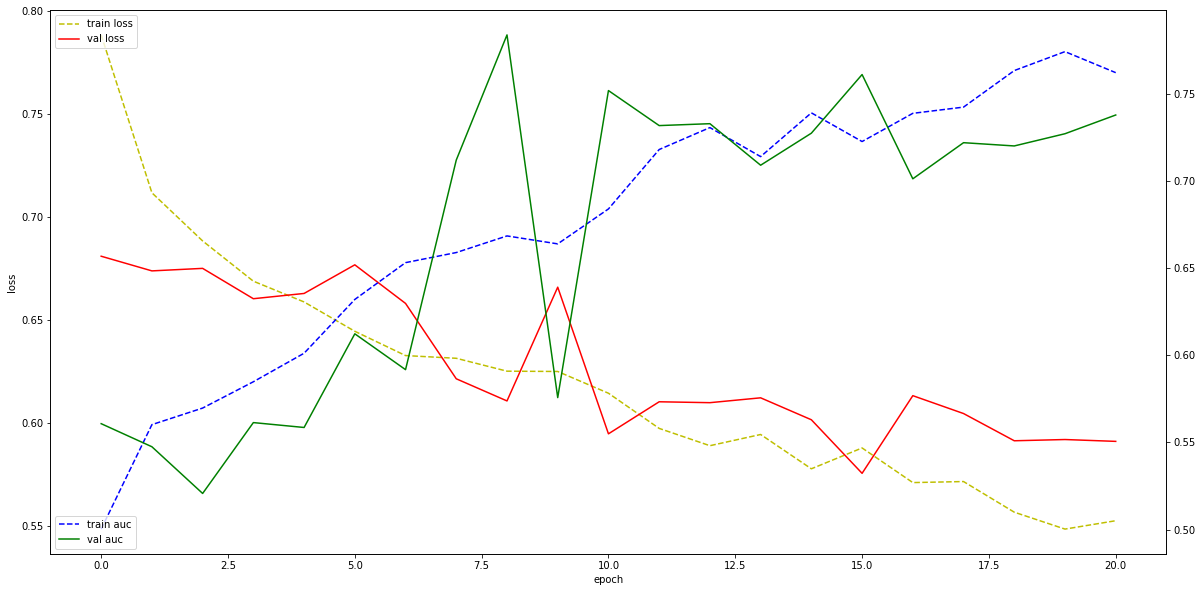

In [56]:
# model auroc 0.719짜리
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(20,10))

#x-axis는 공유하지만 y-axis는 공유x
auc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', linestyle='dashed', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

#acc_ax.plot(hist.history['mean_absolute_error'], 'b', linestyle='dashed',label='train mae')
#acc_ax.plot(hist.history['val_mean_absolute_error'], 'g', label='val mae')
#auc_ax.plot(hist.history['auc'], 'b', linestyle='dashed',label='train auc')
auc_ax.plot(hist.history[list(hist.history.keys())[1]], 'b', linestyle='dashed',label='train auc')
auc_ax.plot(hist.history[list(hist.history.keys())[3]], 'g', label='val auc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
#acc_ax.set_ylim(0.2,1.0)
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
auc_ax.legend(loc='lower left')

plt.show()